# Importing Necessary Libraries

In [163]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
from skimage.transform import resize,rotate
from PIL import Image
import random
import time
import copy
import skimage

# Function for Importing Images and Annotations into lists

In [ ]:
def Extract_images_and_annotations(txt_path,img_path,ann_path):

  with open(txt_path) as file:
    file_names_annoted_images = [line.strip() for line in file]

  Imagefolder_path = img_path
  Imagefile_names = sorted(os.listdir(Imagefolder_path))
  Imagefile_paths = [os.path.join(Imagefolder_path, file_name) for file_name in Imagefile_names]

  Annotationsfolder_path = ann_path
  Annotedfile_names = sorted(os.listdir(Annotationsfolder_path))
  Annotedfile_paths = [os.path.join(Annotationsfolder_path, annoted_name) for annoted_name in Annotedfile_names]

  common_images_1 = []
  common_images_2 = []
  for file_path in Imagefile_paths:
      name, ext = os.path.splitext(os.path.basename(file_path))
      if name in file_names_annoted_images:
          common_images_1.append(file_path)

  for file_path in Annotedfile_paths:
      name, ext = os.path.splitext(os.path.basename(file_path))
      if name in file_names_annoted_images:
          common_images_2.append(file_path)

  image_files = [io.imread(image_path) for image_path in common_images_1]
  annoted_files1 = [io.imread(annoted_path) for annoted_path in common_images_2]
  annoted_files = [a[:,:,:3] for a in annoted_files1]
  return image_files,annoted_files

# PART A

#Importing images and annotations from test folder

In [ ]:
test_txt_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/test/test.txt"
test_imagefolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/test/Images"
test_annotationsfolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/test/Annotations"
test_image_files,test_annoted_files = Extract_images_and_annotations(test_txt_path,test_imagefolder_path,test_annotationsfolder_path)

# Declaring Pascal VOC color mapping

In [ ]:
PascalVOC_colormap = {
    0: (0, 0, 0),        # Background
    1: (128, 0, 0),      # Aeroplane
    2: (0, 128, 0),      # Bicycle
    3: (128, 128, 0),    # Bird
    4: (0, 0, 128),      # Boat
    5: (128, 0, 128),    # Bottle
    6: (0, 128, 128),    # Bus
    7: (128, 128, 128),  # Car
    8: (64, 0, 0),       # Cat
    9: (192, 0, 0),      # Chair
    10: (64, 128, 0),    # Cow
    11: (192, 128, 0),   # Diningtable
    12: (64, 0, 128),    # Dog
    13: (192, 0, 128),   # Horse
    14: (64, 128, 128),  # Motorbike
    15: (192, 128, 128), # Person
    16: (0, 64, 0),      # Potted plant
    17: (128, 64, 0),    # Sheep
    18: (0, 192, 0),     # Sofa
    19: (128, 192, 0),   # Train
    20: (0, 64, 128)     # TV/Monitor
}

# Adding Color Map to mask

In [ ]:
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)
def AddPalette(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

# Defining Transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Defining Custom Dataset Class

In [ ]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_files, annotation_files, color_map, transform=None):
        self.image_files = image_files
        self.annotation_files = annotation_files
        self.color_map = color_map
        self.transform = transform

    def __len__(self):
        return len(self.annotation_files)

    def __getitem__(self, index):
        image = self.image_files[index]
        annotation = self.annotation_files[index]
        mask = np.zeros_like(annotation[:, :, 0])
        
        for class_label, color_codes in self.color_map.items():
          matched_indices = np.all(annotation == color_codes, axis=2)
          mask[matched_indices] = class_label

        if self.transform:
            image = self.transform(image)

        return image, mask

# Setting up Dataloader

In [ ]:
test_dataset = Segmentation_Dataset(test_image_files, test_annoted_files, PascalVOC_colormap, transform)
testdata_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Setting up Model

In [ ]:
weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet50(weights=weights)
model.eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Defining Evaluation Metrics

In [ ]:
def Pixelwise_accuracy(true_label,pred_label):
  return np.mean(true_label == pred_label)

def Mean_IoU(true_label,pred_label,num_classes):
    IoU_of_classes = []
    for labels in range(num_classes):
        Intersection = (pred_label == labels) & (true_label == labels)
        Union = (pred_label == labels) | (true_label == labels)
        if Union.sum()!=0:
          IoU = Intersection.sum() / Union.sum()
          IoU_of_classes.append(IoU)
        #else:
         # IoU_of_classes.append(1)

    return np.mean(IoU_of_classes)

# Testing Images on the Model

In [ ]:
outputs = []
ground_truths = []
for i, (images, masks) in enumerate(testdata_loader):
  with torch.no_grad():

    outputs.append(torch.squeeze(model(images)['out'].argmax(1)).numpy())
    ground_truths.append(torch.squeeze(masks).numpy())
    

#Computing Pixel Accuracy and Mean IoU (Question 2.a)

In [ ]:
pixels_acc = []
mean_iou= []
for i in range(len(outputs)):
  pixels_acc.append(Pixelwise_accuracy(ground_truths[i],outputs[i]))
  mean_iou.append(Mean_IoU(ground_truths[i],outputs[i],21))
print("Pixel Accuracy : {:.2f} %".format(np.mean(pixels_acc)*100))
print("Mean IoU : {:.2f} %".format(np.mean(mean_iou)*100))

Pixel Accuracy : 88.98 %
Mean IoU : 56.10 %


# Visualizing few Output Images 

In [ ]:
def prediction_images_fcn_resnet50(loader,k):
  outputs = []
  ground_truths = []
  for i, (images, masks) in enumerate(loader):
    with torch.no_grad():
      if(i == k):
        break
      outputs.append(torch.squeeze(model(images)['out'].argmax(1)).numpy())
      ground_truths.append(torch.squeeze(masks).numpy())
      output_mask = AddPalette(outputs[i])
      mask = AddPalette(ground_truths[i])
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (10,10))
      axis[0,0].imshow((torch.squeeze(images)).permute(1, 2, 0))
      axis[0,1].imshow(mask)
      axis[0,2].imshow(output_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('True Annotation')
      axis[0,2].title.set_text('Predicted Annotation')
      plt.show()
    


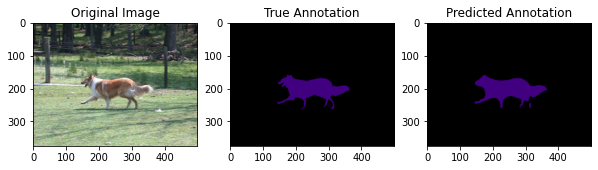

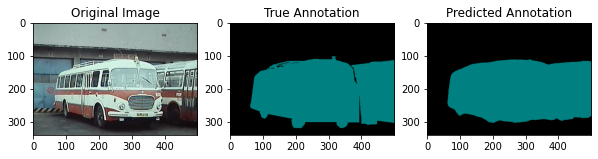

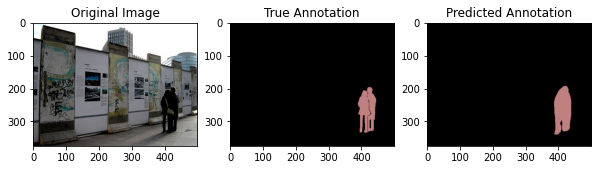

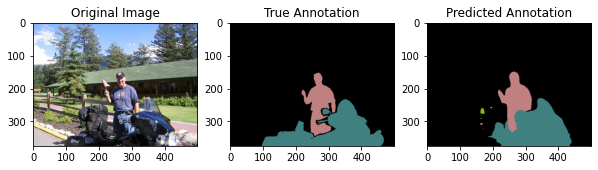

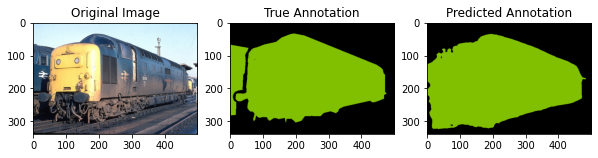

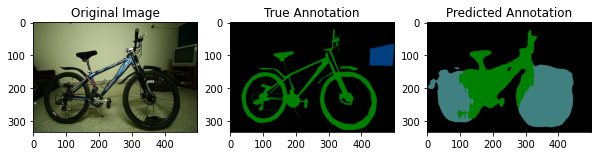

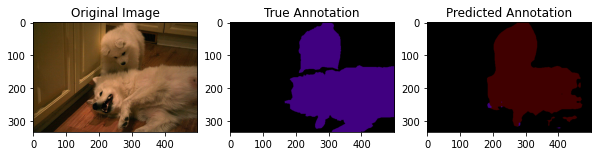

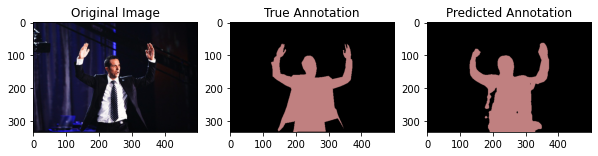

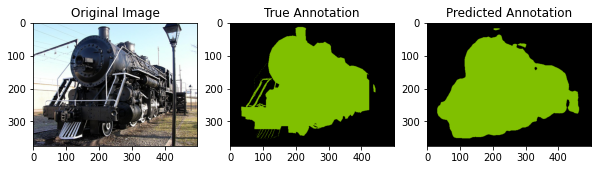

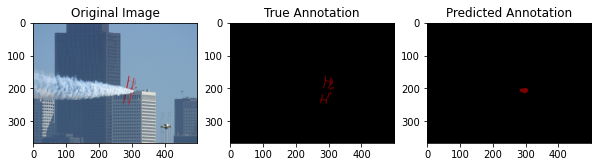

In [ ]:
prediction_images_fcn_resnet50(testdata_loader,10)

# PART B

# Loading Mobilenetv2 model

In [ ]:
mobilenetv2 = torchvision.models.mobilenet_v2(pretrained=True)
net = nn.Sequential(*list(mobilenetv2.children())[:-1])  # Removing last layer

# Bilinear Kernal for initinalizing weights of filters for Transpose Convolution

In [ ]:
# Bilinear Kernal initializes the weights

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    for i in range(out_channels):
        for j in range(in_channels):
            if i == j:
                weight[i, j, :, :] = filt
    return weight

# Adding Transose Convolution Layers

In [ ]:
# Freezing previous layers
for param in net.parameters():
     param.requires_grad=False
num_classes = 21

# Adding new layers (5 blocks)

conv_trans1 = nn.ConvTranspose2d(1280, 512,kernel_size=4, padding=1, stride=2)
conv_trans1.weight.data.copy_(bilinear_kernel(1280, 512, 4));
net.add_module('transpose_conv', conv_trans1)
net.add_module('BatchNorm2d',nn.BatchNorm2d(512))
net.add_module('ReLU6',nn.ReLU(inplace=True))

conv_trans2 = nn.ConvTranspose2d(512, 256,kernel_size=4, padding=1, stride=2)
conv_trans2.weight.data.copy_(bilinear_kernel(512, 256, 4));
net.add_module('transpose_conv2', conv_trans2)
net.add_module('BatchNorm2d2',nn.BatchNorm2d(256))
net.add_module('ReLU62',nn.ReLU(inplace=True))

conv_trans3 = nn.ConvTranspose2d(256, 128,kernel_size=4, padding=1, stride=2)
conv_trans3.weight.data.copy_(bilinear_kernel(256, 128, 4));
net.add_module('transpose_conv3', conv_trans3)
net.add_module('BatchNorm2d3',nn.BatchNorm2d(128))
net.add_module('ReLU63',nn.ReLU(inplace=True))


conv_trans4 = nn.ConvTranspose2d(128, 64,kernel_size=4, padding=1, stride=2)
conv_trans4.weight.data.copy_(bilinear_kernel(128, 64, 4));
net.add_module('transpose_conv4', conv_trans4)
net.add_module('BatchNorm2d4',nn.BatchNorm2d(64))
net.add_module('ReLU64',nn.ReLU(inplace=True))

conv_trans5 = nn.ConvTranspose2d(64, 21,kernel_size=4, padding=1, stride=2)
conv_trans5.weight.data.copy_(bilinear_kernel(64, 21, 4));
net.add_module('transpose_conv5', conv_trans5)
net.add_module('BatchNorm2d5',nn.BatchNorm2d(21))
net.add_module('ReLU65',nn.ReLU(inplace=True))

# Setting Up Datasets and Dataloaders

In [ ]:
train_txt_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/train.txt"
train_imagefolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/Images"
train_annotationsfolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/Annotations"
train_image_files,train_annoted_files = Extract_images_and_annotations(train_txt_path,train_imagefolder_path,train_annotationsfolder_path)

In [ ]:
train_annoted_files = [resize(a, (224, 224),anti_aliasing=True)*255 for a in train_annoted_files]
train_annoted_files = [a.astype(int) for a in train_annoted_files]

In [ ]:
train_dataset = Segmentation_Dataset(train_image_files, train_annoted_files, PascalVOC_colormap, transform1)
traindata_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)


In [ ]:
trainval_txt_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/val.txt"
trainval_imagefolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/Images"
trainval_annotationsfolder_path = "/content/drive/MyDrive/AIP/A2/PascalVOC/trainval/Annotations"
trainval_image_files,trainval_annoted_files = Extract_images_and_annotations(trainval_txt_path,trainval_imagefolder_path,trainval_annotationsfolder_path)

In [ ]:
trainval_annoted_files = [resize(a, (224, 224),anti_aliasing=True)*255 for a in trainval_annoted_files]
trainval_annoted_files = [a.astype(int) for a in trainval_annoted_files]

In [ ]:
trainval_dataset = Segmentation_Dataset(trainval_image_files, trainval_annoted_files, PascalVOC_colormap, transform1)
traindataval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=32, shuffle=False)

In [ ]:
test_annoted_files1 = [resize(a, (224, 224),anti_aliasing=True)*255 for a in test_annoted_files]
test_annoted_files1 = [a.astype(int) for a in test_annoted_files1]

In [ ]:
test_dataset1 = Segmentation_Dataset(test_image_files, test_annoted_files1, PascalVOC_colormap, transform1)
testdata_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=1, shuffle=True)


In [ ]:
dataloader = {'train':traindata_loader, 'val':traindataval_loader}

# Training the Model

In [ ]:
def train_model(model,dataloaders, scheduler, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_loss = np.inf

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0

      for inputs, masks in dataloaders[phase]:
        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop
        

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          masks = masks.clone().squeeze().detach().long()
          outputs = outputs.type(torch.float64)

          loss = criterion(outputs, masks)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
              

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / (len(dataloaders[phase].dataset)*224*224)

      print('{} Loss: {:.16f}'.format(phase, epoch_loss))

      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
params_to_update = []

# Training only the parameters that are newly added

for name,param in net.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

criterion = torch.nn.CrossEntropyLoss(ignore_index = 255)
optimizer = torch.optim.SGD(params_to_update, lr = 0.01, momentum = 0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 1)

In [ ]:
net = train_model(net,dataloader, exp_lr_scheduler, criterion, optimizer)

# Testing the Model

In [ ]:
net.eval()

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [ ]:
outputs1 = []
ground_truths1 = []
for i, (images, masks) in enumerate(testdata_loader1):
  with torch.no_grad():

    outputs1.append(torch.squeeze(net(images).argmax(1)).numpy())
    ground_truths1.append(torch.squeeze(masks).numpy())

# Computing Pixel Accuracy and Mean Iou (Question 2.b)

In [ ]:
pixels_acc1 = []
mean_iou1 = []
for i in range(len(outputs)):
  pixels_acc1.append(Pixelwise_accuracy(ground_truths1[i],outputs1[i]))
  mean_iou1.append(Mean_IoU(ground_truths1[i],outputs1[i],21))
print("Pixel Accuracy : {:.2f} %".format(np.mean(pixels_acc1)*100))
print("Mean IoU : {:.2f} %".format(np.mean(mean_iou1)*100))

Pixel Accuracy : 77.57 %
Mean IoU : 31.39 %


# Visualizing few Output Images

In [ ]:
def prediction_images_net(loader,k):
  outputs = []
  ground_truths = []
  for i, (images, masks) in enumerate(loader):
    with torch.no_grad():
      if(i == k):
        break
      outputs.append(torch.squeeze(net(images).argmax(1)).numpy())
      ground_truths.append(torch.squeeze(masks).numpy())
      output_mask = AddPalette(outputs[i])
      mask = AddPalette(ground_truths[i])
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (10,10))
      axis[0,0].imshow((torch.squeeze(images)).permute(1, 2, 0))
      axis[0,1].imshow(mask)
      axis[0,2].imshow(output_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('True Annotation')
      axis[0,2].title.set_text('Predicted Annotation')
      plt.show()

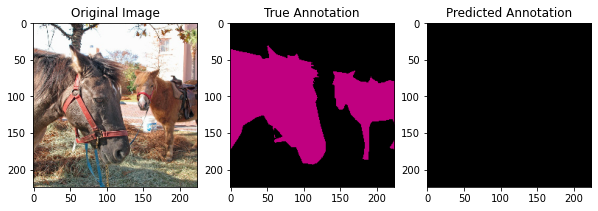

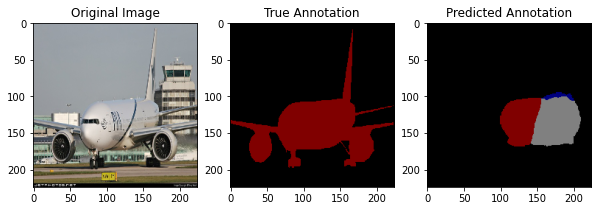

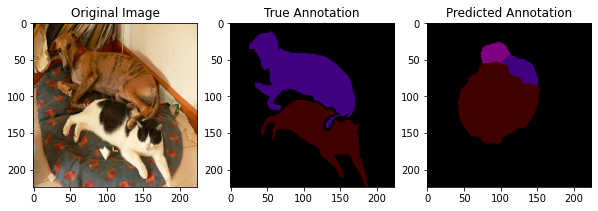

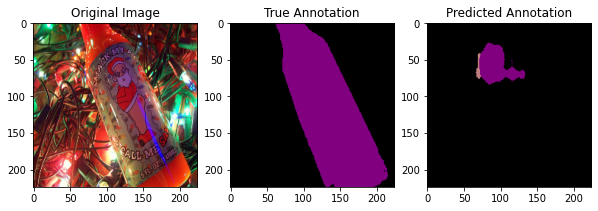

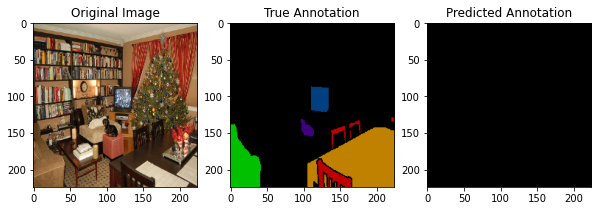

In [ ]:
prediction_images_net(testdata_loader1,5)

# PART C
# Testing test4 and test5 on FCN_Resnet50 and fine-tuned Mobilenetv2

In [187]:
test4  = io.imread("/content/drive/MyDrive/AIP/A2/test4.jpg")
test5 = io.imread("/content/drive/MyDrive/AIP/A2/test5.jpg")
test4_rotated = rotate(test4, 45)
test5_rotated = rotate(test5, 45)
test4_noise = skimage.util.random_noise(test4, mode='gaussian')
test5_noise = skimage.util.random_noise(test5, mode='gaussian')


In [177]:
img_list = [test4,test5,test4_rotated,test5_rotated,test4_noise,test5_noise]

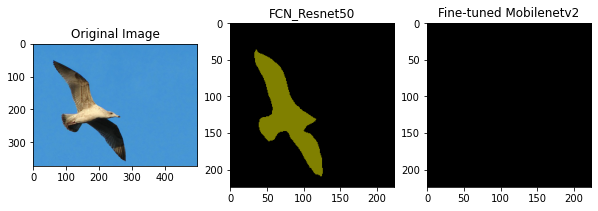

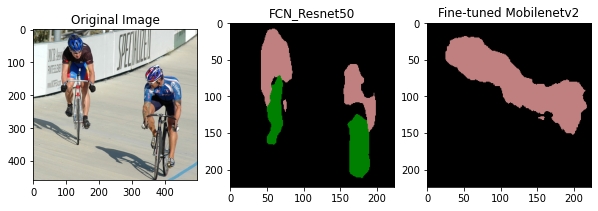

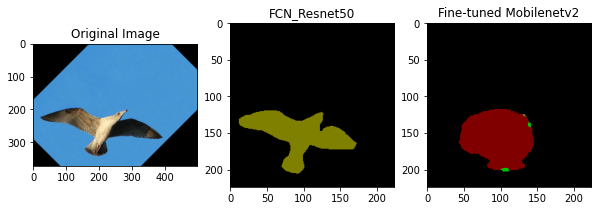

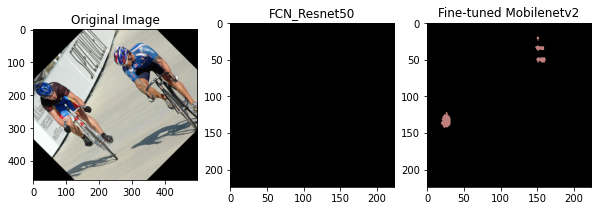

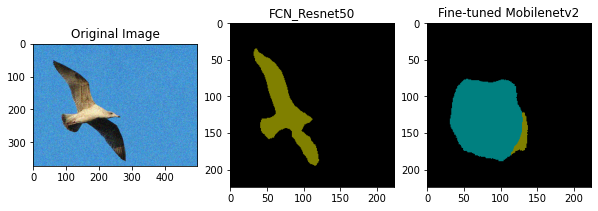

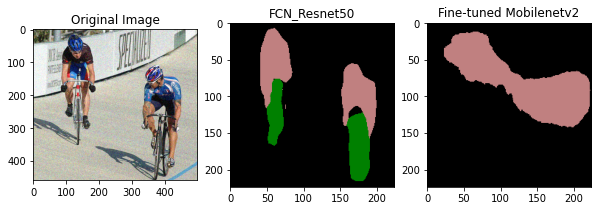

In [192]:
for image in img_list:
  inp = transform1(image).unsqueeze(0)
  fcn_out = AddPalette(torch.squeeze(model(inp.float())['out'].argmax(1)).numpy())
  net_out = AddPalette(torch.squeeze(net(inp.float()).argmax(1)).numpy())
  fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (10,10))
  axis[0,0].imshow(image)
  axis[0,1].imshow(fcn_out)
  axis[0,2].imshow(net_out)
  axis[0,0].title.set_text('Original Image')
  axis[0,1].title.set_text('FCN_Resnet50')
  axis[0,2].title.set_text('Fine-tuned Mobilenetv2')
  plt.show()